<a href="https://colab.research.google.com/github/sunmarknatecom/01_markcv/blob/master/s2_training_class_only_L240208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from glob import glob
import numpy as np
import cv2, os, copy, shutil
import matplotlib.pyplot as plt
from random import randint

# DEEP LEARNING MODULES
import tensorflow as tf
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.optimizers import Adam

from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy
from keras.losses import categorical_crossentropy

1. data/inputData -> normalization
2. data/inputRawData --> 원래
3. data/labelData -> 위치보정 label

In [2]:
MAX_SIZE = 512
split_num = 500
model_path = "/content/drive/MyDrive/Bone_SPECT/models/mymodel_local_{epoch}.h5"
model_summary_path = "/content/drive/MyDrive/Bone_SPECT/training_history_local.pkl"
basic_learning_rate = 3e-5

In [3]:
temp_train_imgs = np.load("/content/drive/MyDrive/Bone_SPECT/data/inputData.npy")
temp_train_lbls = np.load("/content/drive/MyDrive/Bone_SPECT/data/labelData.npy")

In [ ]:
# 0: BG, 1: C, 2: T, 3: L
# Whole spine
temp_train_lbls[temp_train_lbls<=0]=0
temp_train_lbls[temp_train_lbls>1]=1

In [4]:
# L spine
temp_train_lbls[temp_train_lbls<=13]=0
temp_train_lbls[temp_train_lbls>13]=1

In [ ]:
# T spine
temp_train_lbls[temp_train_lbls<=1]=0
temp_train_lbls[temp_train_lbls>=14]=0
temp_train_lbls[temp_train_lbls>=2]=1

In [5]:
np.unique(temp_train_lbls[0])

array([0, 1], dtype=uint16)

In [ ]:
# temp_train_lbls = tf.one_hot(temp_train_lbls, depth=4, dtype=tf.uint8)

In [6]:
train_imgs = temp_train_imgs[:split_num,...]
valid_imgs = temp_train_imgs[split_num:,...]
train_msks = temp_train_lbls[:split_num,...]
valid_msks = temp_train_lbls[split_num:,...]

In [7]:
train_imgs = np.array(train_imgs, dtype=np.float32)
train_msks = np.array(train_msks, dtype=np.float32)
valid_imgs = np.array(valid_imgs, dtype=np.float32)
valid_msks = np.array(valid_msks, dtype=np.float32)

train_msks = np.reshape(train_msks, (*train_msks.shape, 1))
valid_msks = np.reshape(valid_msks, (*valid_msks.shape, 1))

train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs, train_msks))
test_dataset = tf.data.Dataset.from_tensor_slices((valid_imgs, valid_msks))

In [8]:
print(np.shape(train_imgs))
print(np.shape(train_msks))

(500, 512, 256)
(500, 512, 256, 1)


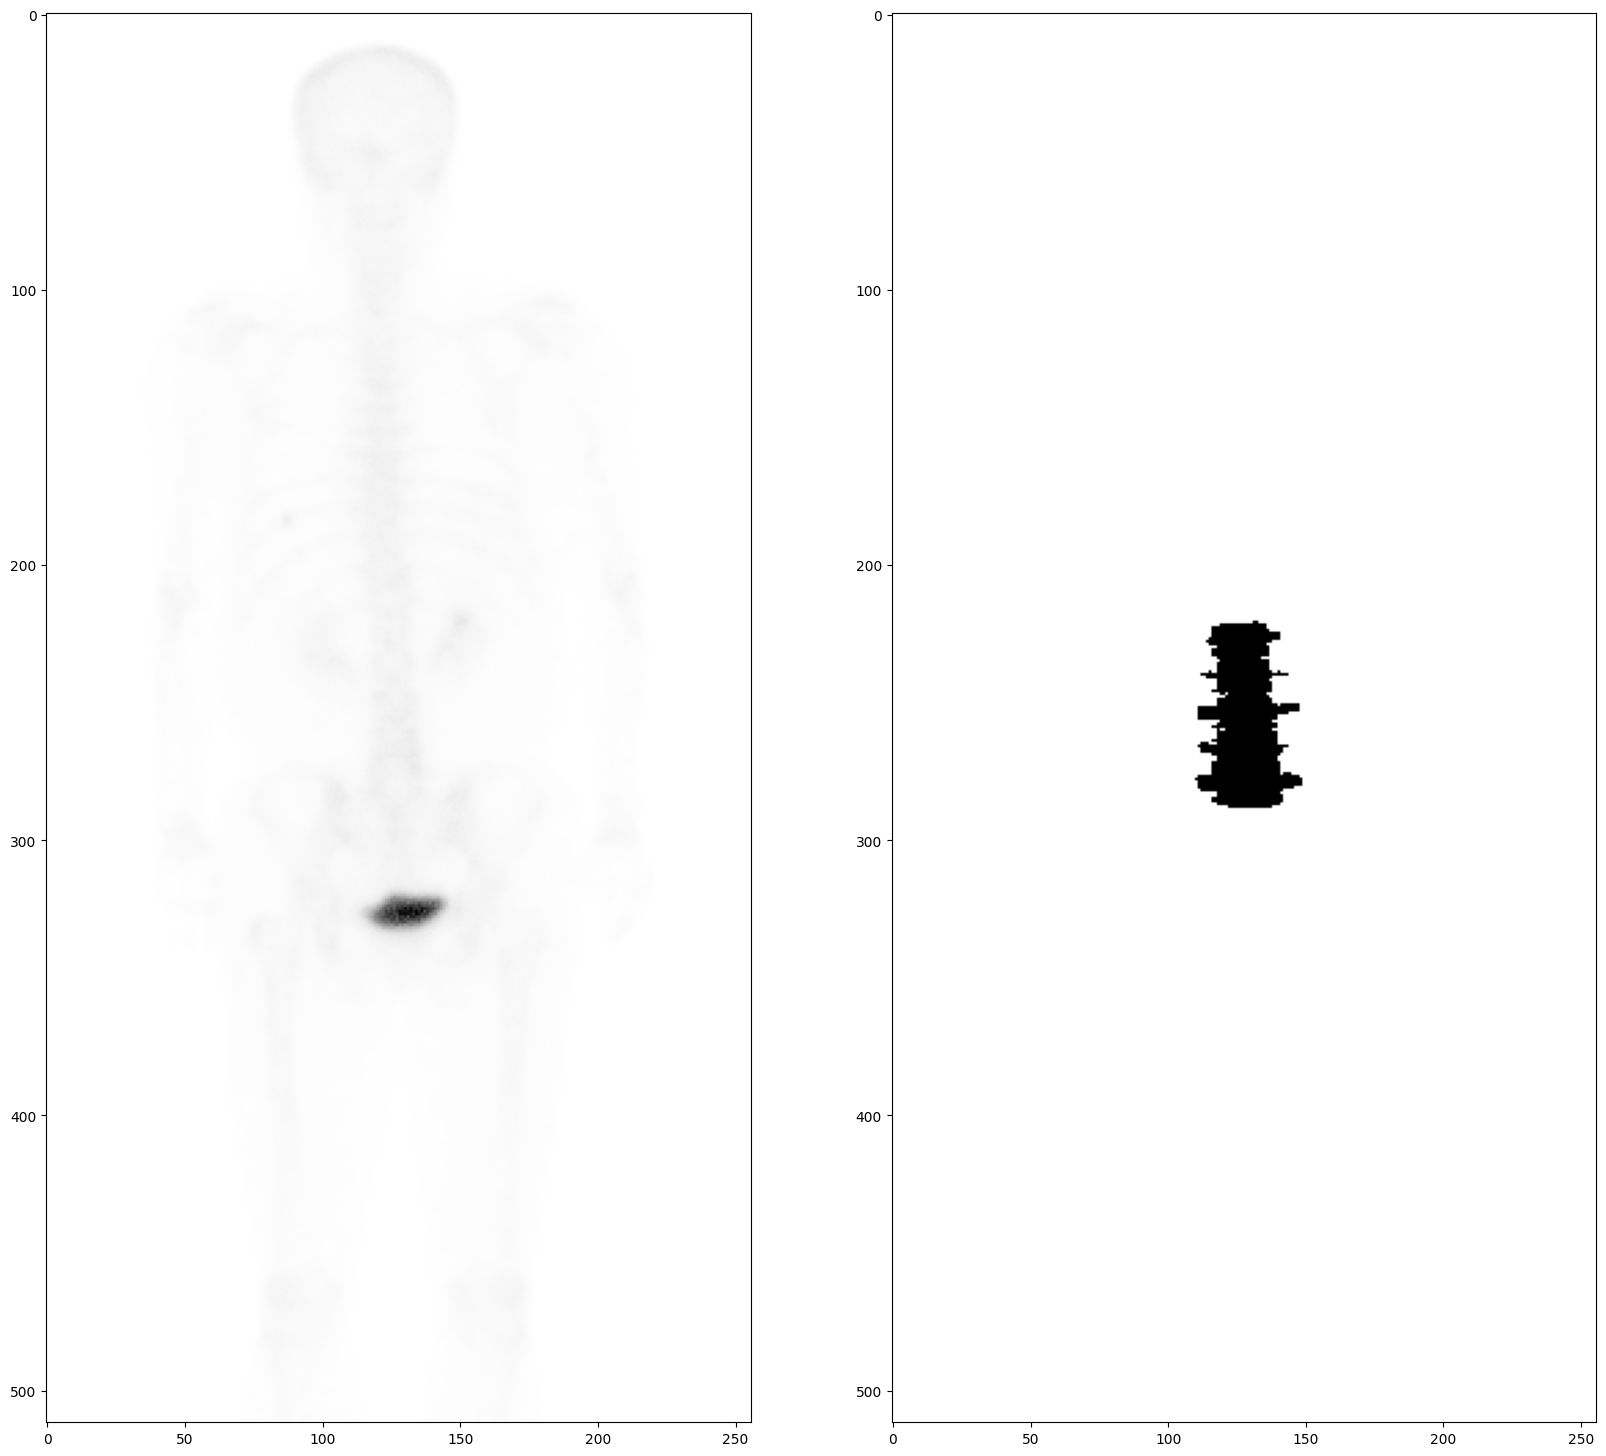

In [9]:
%matplotlib inline

rand_num = randint(1,len(train_imgs))

fig = plt.figure(0, figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(train_imgs[rand_num]*13, cmap='gray_r')
fig.add_subplot(1, 2, 2)
plt.imshow(train_msks[rand_num], cmap='gray_r')

# Construct the model

In [10]:
CLASS_NUM = 1

In [11]:
inputs = Input((MAX_SIZE, 256, 1))
bnorm1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bnorm1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(CLASS_NUM, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

In [12]:
# reference https://github.com/SoftwareImpacts/SIMPAC-2021-46/tree/master

beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def generalized_dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - generalized_dice_coefficient(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss / 2.0

def cce_dice_loss(y_true, y_pred):
    ce_loss = categorical_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    loss = ce_loss + dice
    return loss

In [13]:
initial_learning_rate = basic_learning_rate

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.96,
    staircase=True)

callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    save_best_only=True,
    monitor='val_loss',
    verbose=1)]

In [14]:
model.compile(Adam(learning_rate=lr_schedule), bce_dice_loss, metrics=[binary_crossentropy, generalized_dice_coefficient])

In [15]:
model_history = model.fit(train_imgs, train_msks, batch_size=20, epochs=200, callbacks=callbacks, validation_data=(valid_imgs, valid_msks))

Epoch 1/200
25/25 [==============================] - ETA: 0s - loss: 0.8283 - binary_crossentropy: 0.6819 - generalized_dice_coefficient: 0.0253
Epoch 1: val_loss improved from inf to 0.83387, saving model to /content/drive/MyDrive/Bone_SPECT/models/mymodel_local_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 28s 295ms/step - loss: 0.8283 - binary_crossentropy: 0.6819 - generalized_dice_coefficient: 0.0253 - val_loss: 0.8339 - val_binary_crossentropy: 0.6884 - val_generalized_dice_coefficient: 0.0206
Epoch 2/200
25/25 [==============================] - ETA: 0s - loss: 0.8158 - binary_crossentropy: 0.6552 - generalized_dice_coefficient: 0.0236
Epoch 2: val_loss improved from 0.83387 to 0.82866, saving model to /content/drive/MyDrive/Bone_SPECT/models/mymodel_local_2.h5
25/25 [==============================] - 3s 138ms/step - loss: 0.8158 - binary_crossentropy: 0.6552 - generalized_dice_coefficient: 0.0236 - val_loss: 0.8287 - val_binary_crossentropy: 0.6777 - val_generalized_dice_coefficient: 0.0204
Epoch 3/200
25/25 [==============================] - ETA: 0s - loss: 0.7491 - binary_crossentropy: 0.5156 - generalized_dice_coefficient: 0.0174
Epoch 3: val_loss improved from 0.82866 to 0.73505, saving model to /content/drive/MyDrive/Bone_SPECT/models/my

In [16]:
prd_img = model.predict(np.array([train_imgs[5]]))

1/1 [==============================] - 1s 1s/step


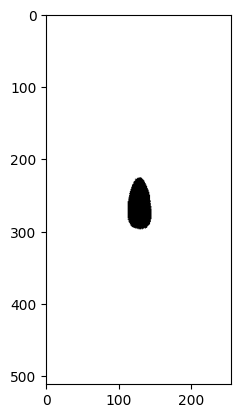

In [17]:
plt.imshow(np.round(np.squeeze(prd_img[0])), cmap='gray_r')
plt.show()

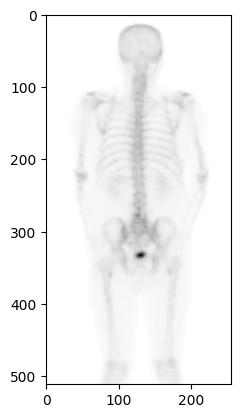

In [18]:
plt.imshow(np.squeeze(train_imgs[5]), cmap="gray_r")
plt.show()

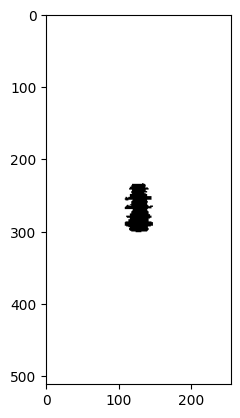

In [19]:
plt.imshow(train_msks[5], cmap="gray_r")
plt.show()

In [20]:
output_img = np.round(np.squeeze(prd_img[0]))

In [21]:
model_path = "/content/drive/MyDrive/Bone_SPECT/models/mymodel_local_{epoch}.h5"
model_summary_path = "/content/drive/MyDrive/Bone_SPECT/training_history_local_Lspine.pkl"

In [22]:
import pickle
with open(model_summary_path, 'wb') as file:
    pickle.dump(model_history.history, file)

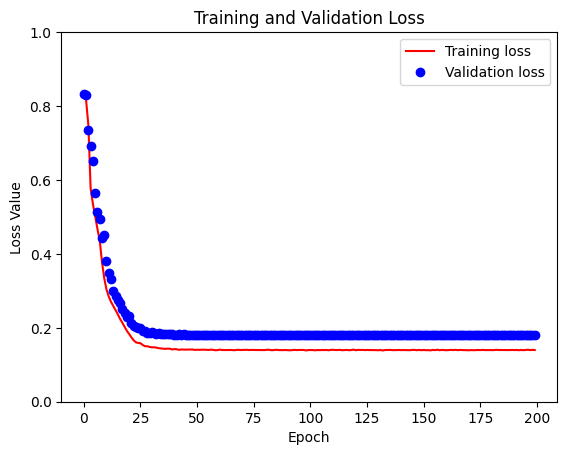

In [23]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
# 재시도시
del model

In [ ]:
# 최대 최소값